In [ ]:
!pip install fsspec
!pip install gcsfs
!pip install transformers
!pip install sentence_transformers
!pip install faiss
!python -m pip install --upgrade faiss faiss-gpu
!pip install p_tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 140 kB 9.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 9.4 MB/s 
     |████████████████████████████████| 271 kB 52.7 MB/s 
     |████████████████████████████████| 94 kB 3.7 MB/s 
     |████████████████████████████████| 144 kB 78.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 7.1 MB/s 
     |████████████████████████████████| 6.6 MB 50.3 MB/s 
     |████████████████████████████████| 596 kB 69.1 MB/s 
     |████████████████████████████████| 101 kB 11.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ln -s "/content/drive/My Drive/Colab Notebooks/tfm"
import sys
sys.path.append('tfm/checkpoints/')
sys.path.append('tfm/outputs/')

Mounted at /content/drive


In [ ]:
import faiss
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from matplotlib import pyplot as plt
from p_tqdm import p_map
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    roc_auc_score,
)
from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
from tqdm.auto import tqdm
from transformers import AutoTokenizer, TFBertForSequenceClassification

In [ ]:
filepath = "../../data/outputs/dataset_2021_paragraph"
filepath = "tfm/outputs/dataset_2021_paragraph" # Filepath COLAB
filepath = "https://storage.googleapis.com/tfm_aideas_datasets/dataset_2021_paragraph" # Filepath GCloud

In [ ]:
#### Código para migrar las labels del dataset original etiquetado al nuevo dataset_2021_paragraph_annotated ####
#### Mejor no ejecutar en COLAB para guardar CSV ####
df_no_labels = pd.read_csv(f"{filepath}.csv", sep=";", index_col=0, parse_dates=["date"])

df_hg = pd.read_csv("tfm/outputs/hg_subdataset_paragraph_etiquetado.csv", sep=";", parse_dates=["date"])
df_rs = pd.read_csv("tfm/outputs/rs_subdataset_paragraph_etiquetado.csv", sep=";", parse_dates=["date"])
df_annotated_labels = pd.concat([df_hg,df_rs]).reset_index(drop=True)

old_columns = ["finanzas_news_s_n", "impacto_news_s_n", "topic", "finanzas_s_n", "impacto_s_n"]
new_columns = ["finanzas_tag_news_s_n", "impacto_tag_news_s_n", "topic_tag_news", "finanzas_tag_s_n", "impacto_tag_s_n"]

notna_indexes = df_annotated_labels.loc[:,old_columns].dropna().index
df_annotated_labels = df_annotated_labels.loc[notna_indexes,:]

for idx, row in df_annotated_labels.iterrows():
    for old_label, new_label in zip(old_columns, new_columns):
        df_no_labels.loc[(df_no_labels.body == row.body) & (df_no_labels.title == row.title), new_label] = df_annotated_labels.loc[idx, old_label]

df_no_labels.to_csv(f"{filepath}_annotated.csv", sep=";")
df_total_labels = df_no_labels.copy()

In [ ]:
df_total_labels = pd.read_csv(f"{filepath}_annotated.csv", sep=";", index_col=0, parse_dates=["date"], low_memory=False)

In [ ]:
finance_label = df_total_labels.finanzas_tag_s_n.isin([0, 1])
dataset_labels = df_total_labels[finance_label]
dataset_unlabelled = df_total_labels[~finance_label]

In [ ]:
# Para no entrenar varias veces con los mismos párrafos debido a que hayan sido asignados
# a diferentes tickers
dataset_labels.drop_duplicates(subset=["body"], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [ ]:
dataset_labels.finanzas_tag_s_n.value_counts()/sum(dataset_labels.finanzas_tag_s_n.value_counts())

1.0    0.856215
0.0    0.143785
Name: finanzas_tag_s_n, dtype: float64

In [ ]:
sentences = dataset_labels.copy().set_index("pk_paragraph").body

In [ ]:
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2', device='cuda')
embeddings = model.encode(sentences.tolist())

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.77k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/723 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/402 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [ ]:
d = 768
index = faiss.IndexFlatIP(d)
faiss.normalize_L2(embeddings)
index.add(embeddings)

In [ ]:
# Versión multithreading:

neighbors = 50
similarity_threshold = 0.7
i_query = list(sentences.iteritems())

def calculate_cosine_df(i_query, query_embedding):
    results = {}
    i, query = i_query
    distances, indices = index.search(query_embedding.reshape(1,d), neighbors)
    idx_sentences = sentences.index[indices[0]]
    mask1 = ~(idx_sentences == i)
    mask2 = distances[0] > similarity_threshold
    mask = mask1 * mask2
    length = sum(mask)
    if length > 0:
        idx_sentences = idx_sentences[mask]
        distances = distances[0, mask]
        indices = indices[0, mask]    
        results["first_idx"] = np.repeat(i, length)
        results["first_body"] = np.repeat(query, length)
        results["second_idx"] = idx_sentences
        results["second_body"] = sentences.iloc[indices]
        results["cosine"] = distances
    return results

results = p_map(calculate_cosine_df, i_query, embeddings)

converted_results = {}
converted_results["first_idx"] = []
converted_results["first_body"] = []
converted_results["second_idx"] = []
converted_results["second_body"] = []
converted_results["cosine"] = []
for res in results:
    if len(res) == 0:
        continue
    converted_results["first_idx"].extend(res["first_idx"])
    converted_results["first_body"].extend(res["first_body"])
    converted_results["second_idx"].extend(res["second_idx"])
    converted_results["second_body"].extend(res["second_body"])
    converted_results["cosine"].extend(res["cosine"])  

res_df = pd.DataFrame(converted_results)

  0%|          | 0/2156 [00:00<?, ?it/s]

In [ ]:
df_no_duplicates = res_df[~pd.DataFrame(np.sort(res_df[['first_body','second_body']], axis=1), index=res_df.index).duplicated()]
df_sorted = df_no_duplicates.sort_values('cosine', ascending=False).dropna()

In [ ]:
mask = ((df_sorted.first_body.str.len() < 49) & (df_sorted.second_body.str.len() < 49) & (df_sorted.cosine > 0.8))

In [ ]:
bodies_exclude = df_sorted[mask].first_body.to_list()
bodies_exclude.extend(df_sorted[mask].second_body.to_list())

In [ ]:
bodies_exclude = list(set(bodies_exclude))

In [ ]:
dataset_labels = dataset_labels[~dataset_labels.body.isin(bodies_exclude)]

In [ ]:
dataset_labels.finanzas_tag_s_n.value_counts()/sum(dataset_labels.finanzas_tag_s_n.value_counts())

1.0    0.848337
0.0    0.151663
Name: finanzas_tag_s_n, dtype: float64

# Transfer Learning con BETO

In [ ]:
N_LABELS = len(np.unique(dataset_labels.finanzas_tag_s_n))

In [ ]:
checkpoint = "dccuchile/bert-base-spanish-wwm-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Downloading:   0%|          | 0.00/310 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/650 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/242k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/475k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/134 [00:00<?, ?B/s]

In [ ]:
model = TFBertForSequenceClassification.from_pretrained(checkpoint, num_labels=N_LABELS)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# model.layers[1].rate = 0.1

In [ ]:
model.layers[0].trainable=False

In [ ]:
model.compile(
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
optimizer=Adam(learning_rate=0.0001),
metrics=['accuracy']
)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(dataset_labels.body_no_entities, dataset_labels.finanzas_tag_s_n, test_size=0.2, random_state=42)

In [ ]:
x_train = tokenizer(x_train.tolist(), padding="max_length", truncation=True, return_tensors="tf")

In [ ]:
x_test = tokenizer(x_test.tolist(), padding="max_length", truncation=True, return_tensors="tf")

In [ ]:
N_EPOCAS = 150

In [ ]:
# filepath_checkpoint = './checkpoints/finanzas_tag_s_n/checkpoint'
filepath_checkpoint = 'tfm/checkpoints/finanzas_tag_s_n/checkpoint' # Filepath COLAB

model_checkpoint_callback = ModelCheckpoint(
    filepath=filepath_checkpoint,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

early_stopping = EarlyStopping(monitor='val_loss', patience=20, mode='min')

hist = model.fit(
    dict(x_train),
    y_train,
    batch_size=128,
    epochs=N_EPOCAS,
    validation_split=0.1,
    callbacks=[model_checkpoint_callback, early_stopping]
    )

Epoch 1/150
12/12 [==============================] - 57s 4s/step - loss: 0.7044 - accuracy: 0.4779 - val_loss: 0.6663 - val_accuracy: 0.6890
Epoch 2/150
12/12 [==============================] - 44s 4s/step - loss: 0.6026 - accuracy: 0.8063 - val_loss: 0.6078 - val_accuracy: 0.7500
Epoch 3/150
12/12 [==============================] - 43s 4s/step - loss: 0.5328 - accuracy: 0.8457 - val_loss: 0.5745 - val_accuracy: 0.7622
Epoch 4/150
12/12 [==============================] - 44s 4s/step - loss: 0.4863 - accuracy: 0.8552 - val_loss: 0.5587 - val_accuracy: 0.7683
Epoch 5/150
12/12 [==============================] - 42s 3s/step - loss: 0.4557 - accuracy: 0.8532 - val_loss: 0.5520 - val_accuracy: 0.7683
Epoch 6/150
12/12 [==============================] - 41s 3s/step - loss: 0.4369 - accuracy: 0.8532 - val_loss: 0.5499 - val_accuracy: 0.7683
Epoch 7/150
12/12 [==============================] - 41s 3s/step - loss: 0.4264 - accuracy: 0.8545 - val_loss: 0.5490 - val_accuracy: 0.7683
Epoch 8/150
1

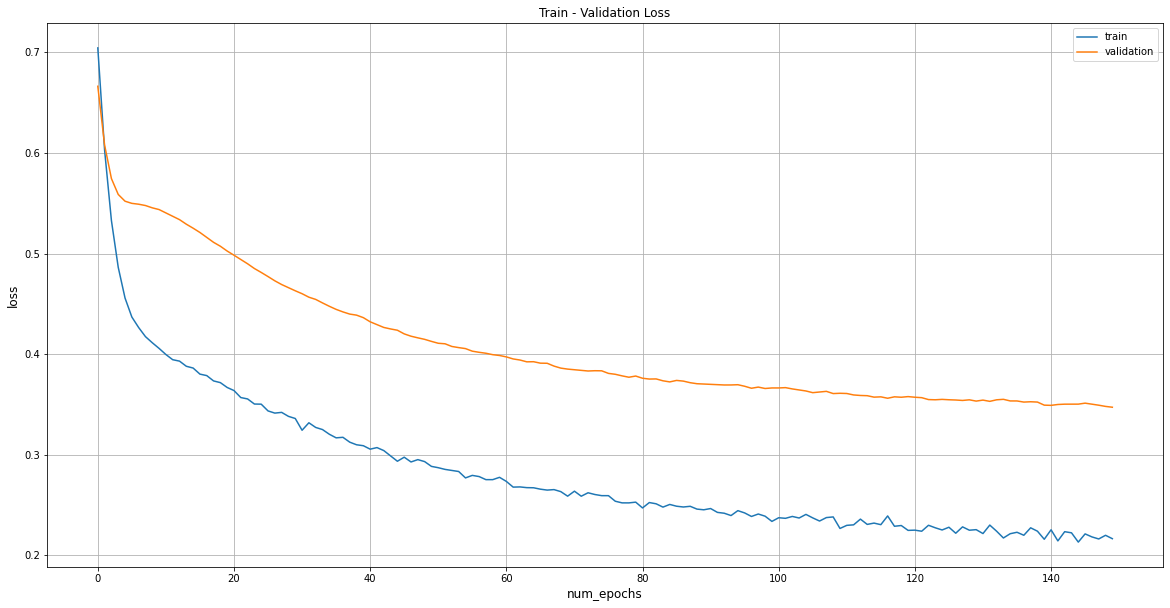

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Loss")
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')
plt.grid()
plt.show()

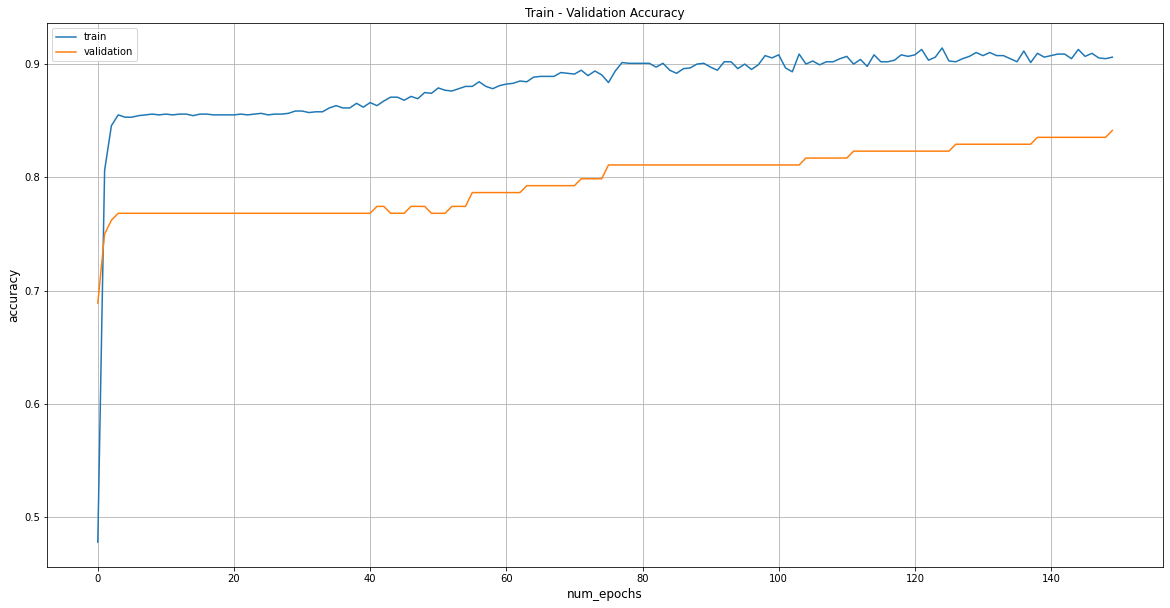

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Accuracy")
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')
plt.grid()
plt.show()

In [ ]:
model.load_weights(filepath_checkpoint)
model.evaluate(x_test.data, y_test)

14/14 [==============================] - 10s 712ms/step - loss: 0.2414 - accuracy: 0.9005


[0.24144314229488373, 0.9004629850387573]

In [ ]:
# Comparativa con una predicción por clase mayoritaria de train:

pd.Series(y_train).value_counts()/sum(pd.Series(y_train).value_counts())

1.0    0.857889
0.0    0.142111
Name: finanzas_tag_s_n, dtype: float64

In [ ]:
y_pred = model.predict(x_test.data)

In [ ]:
y_pred = y_pred.logits.argmax(axis=1)

In [ ]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.81      0.45      0.57        65
         1.0       0.91      0.98      0.94       367

    accuracy                           0.90       432
   macro avg       0.86      0.71      0.76       432
weighted avg       0.89      0.90      0.89       432



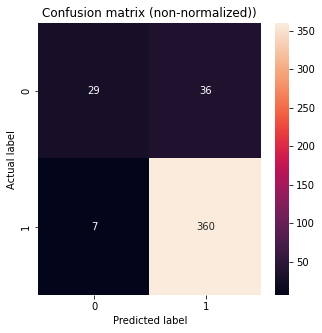

In [ ]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion matrix (non-normalized))")
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")


plot_cm(y_test, y_pred)

In [ ]:
def func_apply(row):
    if (not type(row.body_no_entities)==str):    
        row.body_no_entities = str(row.body_no_entities)
    x = tokenizer(row.body_no_entities, padding="max_length", truncation=True, return_tensors="tf")
    y_pred = model.predict(x.data)
    row['finanzas_tag_s_n'] = int(y_pred.logits.argmax(axis=1)[0])    
    row['finanzas_tag_s_n_proba'] = tf.nn.softmax(y_pred.logits).numpy().max(axis=1)[0]
    return row

In [ ]:
# tqdm.pandas()
# df_total_labels["finanzas_tag_s_n_proba"] = np.NaN
# df_total_labels.loc[finance_label, "finanzas_tag_s_n_proba"] = 1.
# df_total_labels.loc[~finance_label] = df_total_labels.loc[~finance_label].progress_apply(lambda row : func_apply(row), axis=1)

In [ ]:
# df_total_labels.to_csv(f'{filepath}_predict_finanzas_tag_s_n.csv', sep=";")

# Transfer Learning con BETO con KFold

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 1...
Epoch 1/70
52/52 [==============================] - 72s 1s/step - loss: 0.5840 - accuracy: 0.7221 - val_loss: 0.5051 - val_accuracy: 0.7989
Epoch 2/70
52/52 [==============================] - 48s 927ms/step - loss: 0.4255 - accuracy: 0.8550 - val_loss: 0.4831 - val_accuracy: 0.7989
Epoch 3/70
52/52 [==============================] - 48s 926ms/step - loss: 0.3993 - accuracy: 0.8556 - val_loss: 0.4694 - val_accuracy: 0.7989
Epoch 4/70
52/52 [==============================] - 48s 925ms/step - loss: 0.3808 - accuracy: 0.8562 - val_loss: 0.4525 - val_accuracy: 0.7989
Epoch 5/70
52/52 [==============================] - 48s 925ms/step - loss: 0.3668 - accuracy: 0.8562 - val_loss: 0.4331 - val_accuracy: 0.7989
Epoch 6/70
52/52 [==============================] - 48s 925ms/step - loss: 0.3575 - accuracy: 0.8568 - val_loss: 0.4153 - val_accuracy: 0.7989
Epoch 7/70
52/52 [==============================] - 48s 926ms/step - loss: 0.3456 - accuracy: 0.8580 - val_loss: 0.4000 -

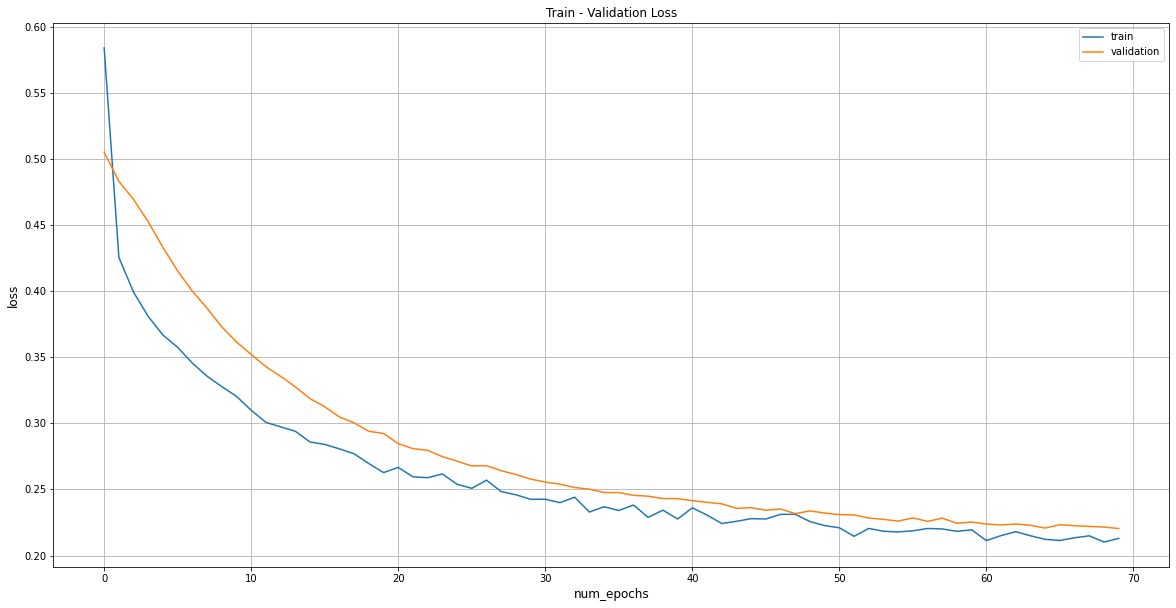

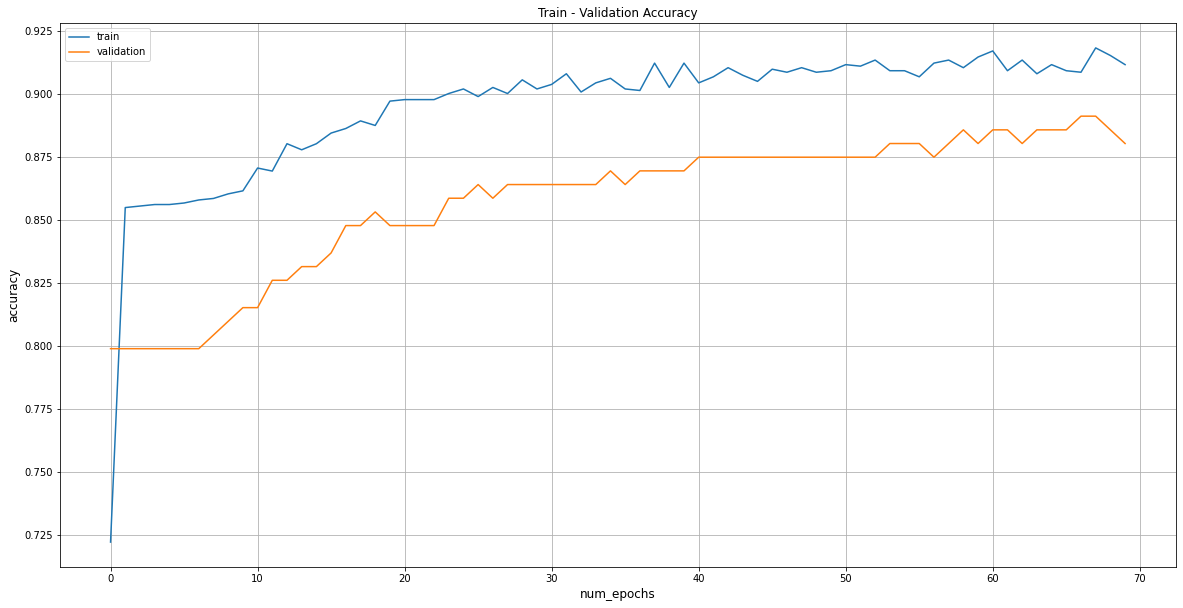

7/7 [==============================] - 5s 674ms/step - loss: 0.2881 - accuracy: 0.8878
Accuracy: 0.8878048658370972


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 2...
Epoch 1/70
52/52 [==============================] - 65s 1s/step - loss: 0.5288 - accuracy: 0.8187 - val_loss: 0.4871 - val_accuracy: 0.8098
Epoch 2/70
52/52 [==============================] - 48s 926ms/step - loss: 0.4246 - accuracy: 0.8538 - val_loss: 0.4701 - val_accuracy: 0.8098
Epoch 3/70
52/52 [==============================] - 48s 926ms/step - loss: 0.4038 - accuracy: 0.8538 - val_loss: 0.4558 - val_accuracy: 0.8098
Epoch 4/70
52/52 [==============================] - 48s 926ms/step - loss: 0.3883 - accuracy: 0.8538 - val_loss: 0.4371 - val_accuracy: 0.8098
Epoch 5/70
52/52 [==============================] - 48s 925ms/step - loss: 0.3791 - accuracy: 0.8538 - val_loss: 0.4217 - val_accuracy: 0.8098
Epoch 6/70
52/52 [==============================] - 48s 925ms/step - loss: 0.3662 - accuracy: 0.8538 - val_loss: 0.4050 - val_accuracy: 0.8098
Epoch 7/70
52/52 [==============================] - 48s 926ms/step - loss: 0.3509 - accuracy: 0.8538 - val_loss: 0.3917 -

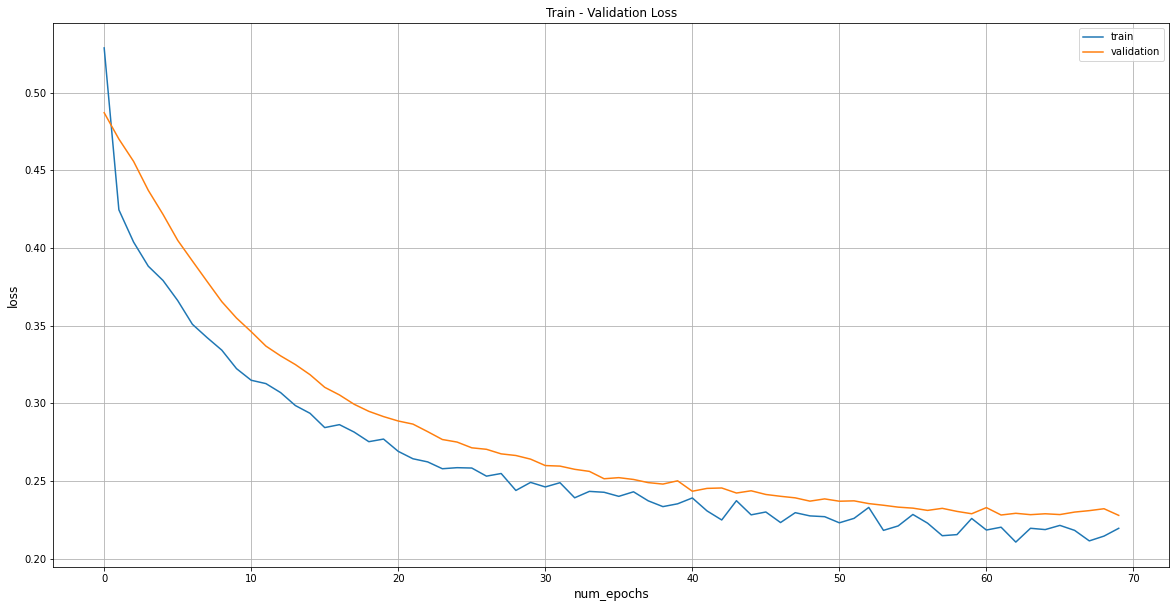

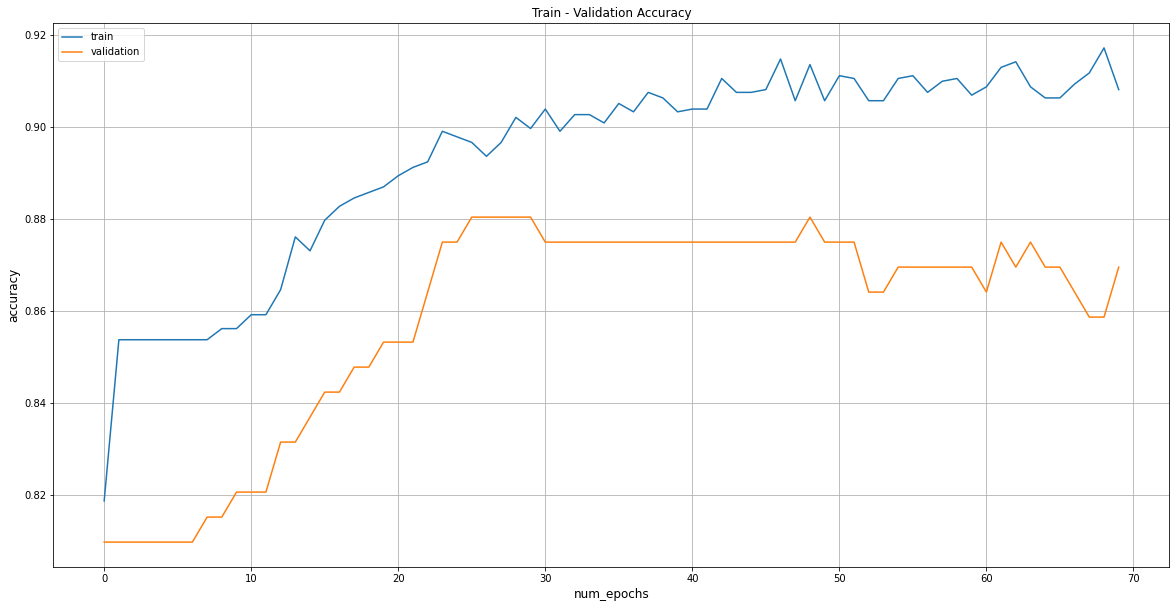

7/7 [==============================] - 5s 674ms/step - loss: 0.2478 - accuracy: 0.8878
Accuracy: 0.8878048658370972


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 3...
Epoch 1/70
52/52 [==============================] - 64s 1s/step - loss: 0.4922 - accuracy: 0.8489 - val_loss: 0.4858 - val_accuracy: 0.8098
Epoch 2/70
52/52 [==============================] - 48s 927ms/step - loss: 0.4228 - accuracy: 0.8502 - val_loss: 0.4664 - val_accuracy: 0.8098
Epoch 3/70
52/52 [==============================] - 48s 925ms/step - loss: 0.4044 - accuracy: 0.8502 - val_loss: 0.4460 - val_accuracy: 0.8098
Epoch 4/70
52/52 [==============================] - 48s 926ms/step - loss: 0.3919 - accuracy: 0.8502 - val_loss: 0.4240 - val_accuracy: 0.8098
Epoch 5/70
52/52 [==============================] - 48s 927ms/step - loss: 0.3755 - accuracy: 0.8502 - val_loss: 0.4046 - val_accuracy: 0.8098
Epoch 6/70
52/52 [==============================] - 48s 926ms/step - loss: 0.3599 - accuracy: 0.8502 - val_loss: 0.3883 - val_accuracy: 0.8098
Epoch 7/70
52/52 [==============================] - 48s 926ms/step - loss: 0.3551 - accuracy: 0.8502 - val_loss: 0.3736 -

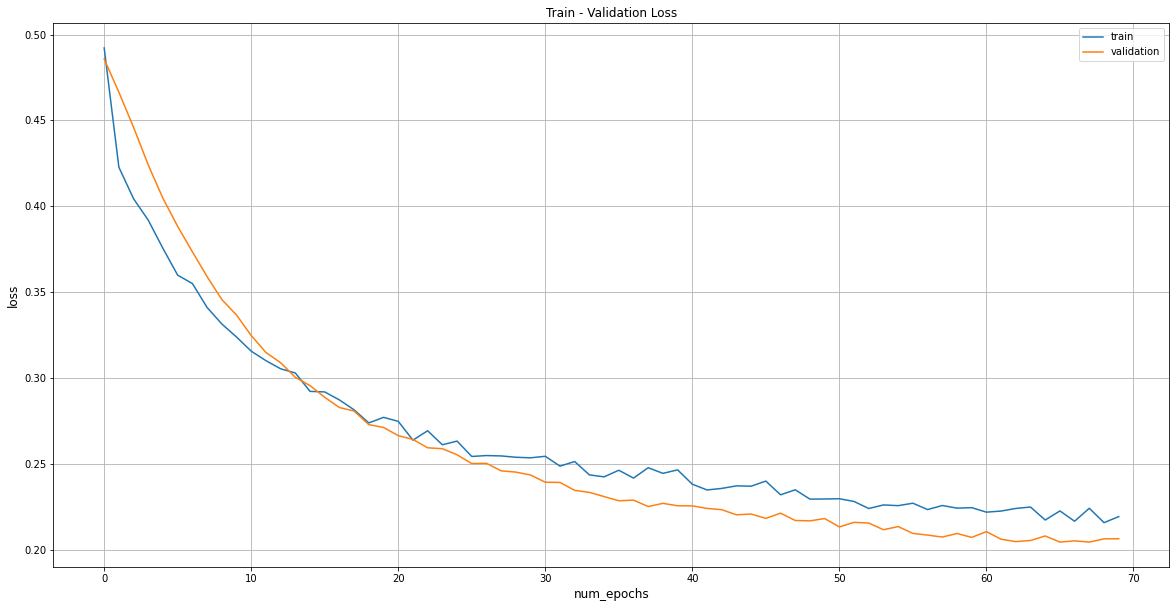

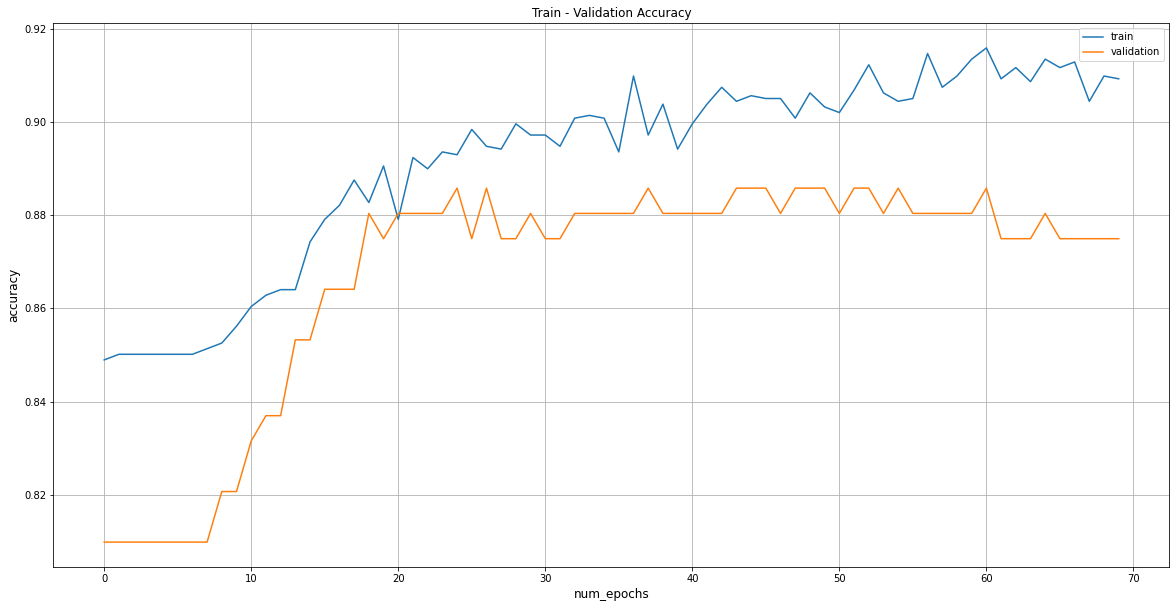

7/7 [==============================] - 5s 674ms/step - loss: 0.2460 - accuracy: 0.9024
Accuracy: 0.9024389982223511


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 4...
Epoch 1/70
52/52 [==============================] - 64s 1s/step - loss: 0.5194 - accuracy: 0.8248 - val_loss: 0.5314 - val_accuracy: 0.7772
Epoch 2/70
52/52 [==============================] - 48s 926ms/step - loss: 0.4298 - accuracy: 0.8508 - val_loss: 0.5261 - val_accuracy: 0.7772
Epoch 3/70
52/52 [==============================] - 48s 925ms/step - loss: 0.4100 - accuracy: 0.8514 - val_loss: 0.5098 - val_accuracy: 0.7772
Epoch 4/70
52/52 [==============================] - 48s 925ms/step - loss: 0.3928 - accuracy: 0.8514 - val_loss: 0.4871 - val_accuracy: 0.7772
Epoch 5/70
52/52 [==============================] - 48s 926ms/step - loss: 0.3810 - accuracy: 0.8514 - val_loss: 0.4687 - val_accuracy: 0.7772
Epoch 6/70
52/52 [==============================] - 48s 925ms/step - loss: 0.3691 - accuracy: 0.8514 - val_loss: 0.4498 - val_accuracy: 0.7772
Epoch 7/70
52/52 [==============================] - 48s 926ms/step - loss: 0.3610 - accuracy: 0.8526 - val_loss: 0.4325 -

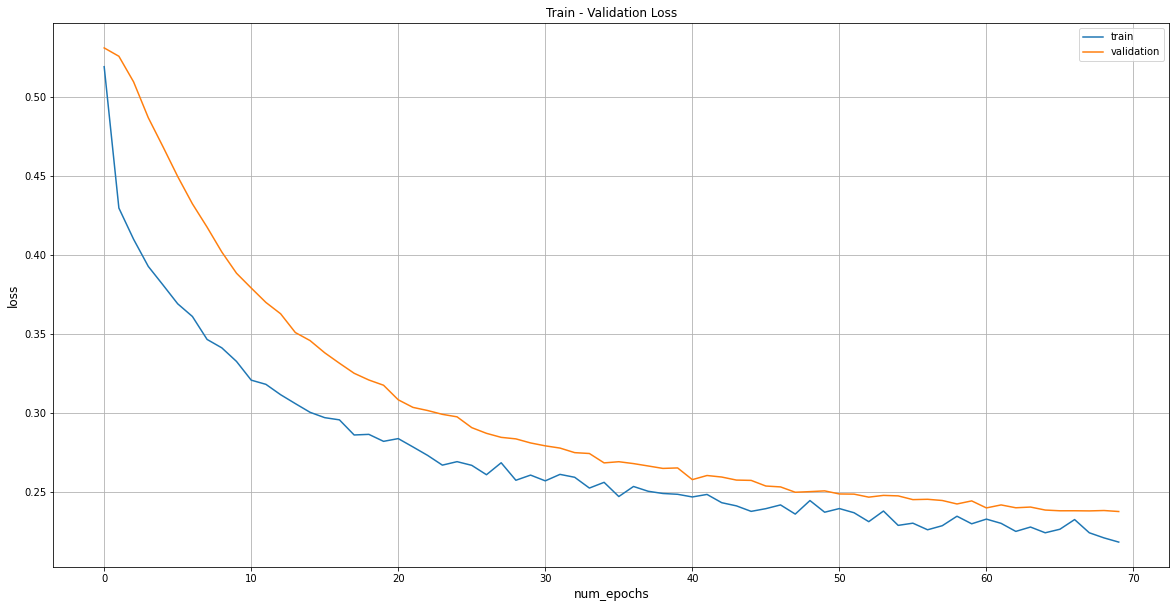

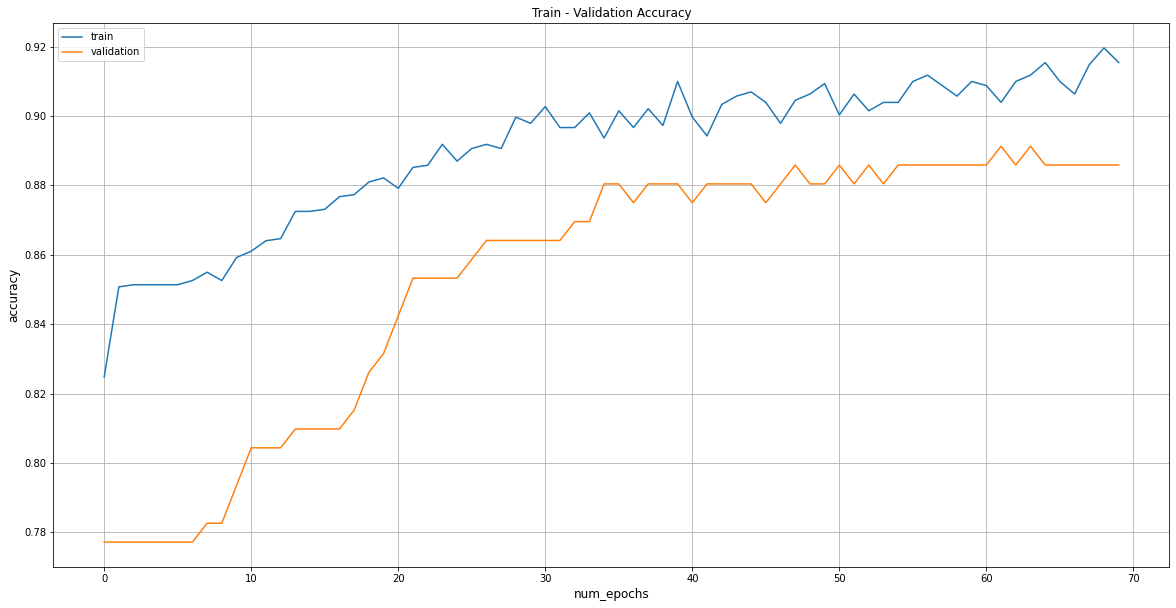

7/7 [==============================] - 5s 675ms/step - loss: 0.1808 - accuracy: 0.9268
Accuracy: 0.9268292784690857


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 5...
Epoch 1/70
52/52 [==============================] - 64s 1s/step - loss: 0.5203 - accuracy: 0.8400 - val_loss: 0.4843 - val_accuracy: 0.8207
Epoch 2/70
52/52 [==============================] - 48s 927ms/step - loss: 0.4207 - accuracy: 0.8575 - val_loss: 0.4622 - val_accuracy: 0.8207
Epoch 3/70
52/52 [==============================] - 48s 927ms/step - loss: 0.4014 - accuracy: 0.8575 - val_loss: 0.4423 - val_accuracy: 0.8207
Epoch 4/70
52/52 [==============================] - 48s 927ms/step - loss: 0.3870 - accuracy: 0.8575 - val_loss: 0.4238 - val_accuracy: 0.8207
Epoch 5/70
52/52 [==============================] - 48s 926ms/step - loss: 0.3731 - accuracy: 0.8569 - val_loss: 0.4054 - val_accuracy: 0.8207
Epoch 6/70
52/52 [==============================] - 48s 927ms/step - loss: 0.3601 - accuracy: 0.8575 - val_loss: 0.3867 - val_accuracy: 0.8207
Epoch 7/70
52/52 [==============================] - 48s 927ms/step - loss: 0.3495 - accuracy: 0.8575 - val_loss: 0.3715 -

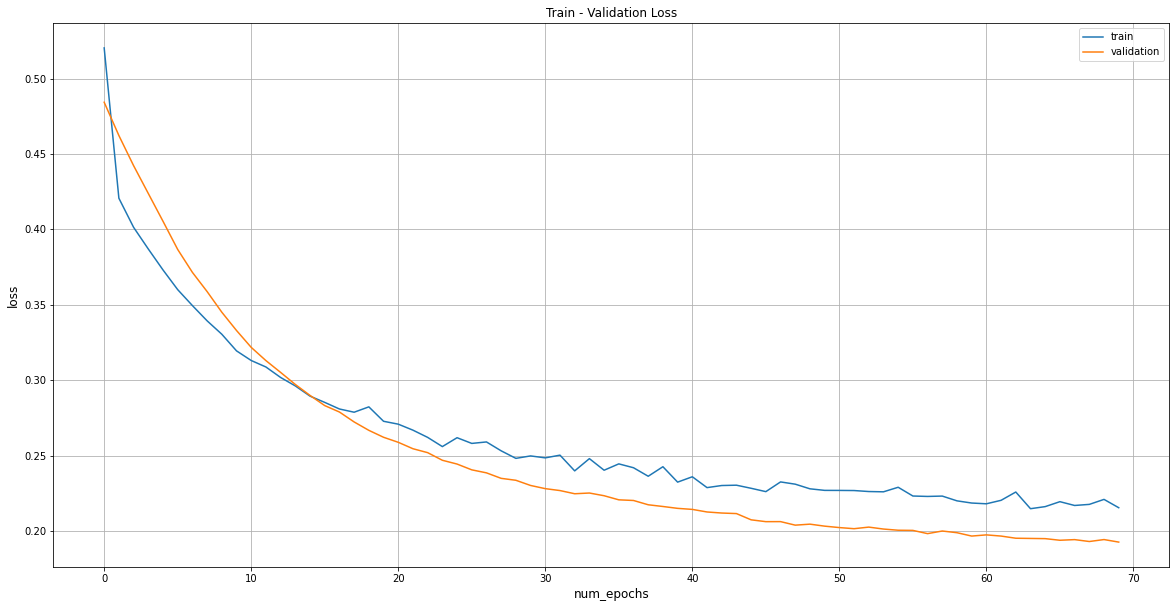

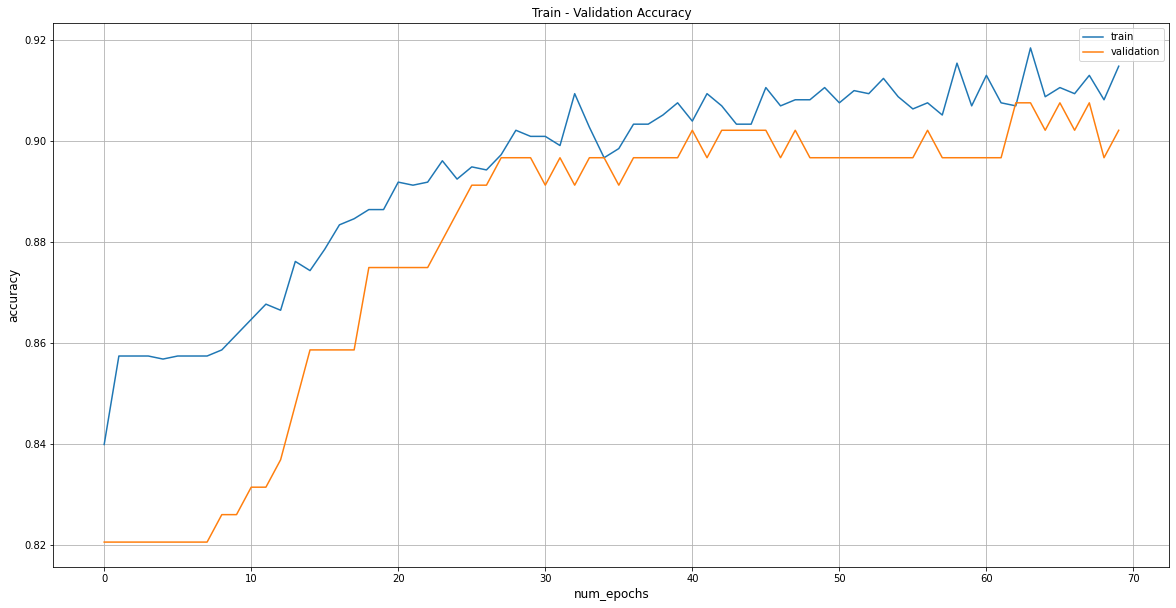

7/7 [==============================] - 5s 672ms/step - loss: 0.2763 - accuracy: 0.8676
Accuracy: 0.8676470518112183


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 6...
Epoch 1/70
52/52 [==============================] - 64s 1s/step - loss: 0.5358 - accuracy: 0.8188 - val_loss: 0.5023 - val_accuracy: 0.8098
Epoch 2/70
52/52 [==============================] - 48s 928ms/step - loss: 0.4276 - accuracy: 0.8527 - val_loss: 0.4893 - val_accuracy: 0.8098
Epoch 3/70
52/52 [==============================] - 48s 927ms/step - loss: 0.4089 - accuracy: 0.8527 - val_loss: 0.4732 - val_accuracy: 0.8098
Epoch 4/70
52/52 [==============================] - 48s 930ms/step - loss: 0.3952 - accuracy: 0.8527 - val_loss: 0.4573 - val_accuracy: 0.8098
Epoch 5/70
52/52 [==============================] - 48s 928ms/step - loss: 0.3806 - accuracy: 0.8527 - val_loss: 0.4411 - val_accuracy: 0.8098
Epoch 6/70
52/52 [==============================] - 48s 928ms/step - loss: 0.3696 - accuracy: 0.8527 - val_loss: 0.4226 - val_accuracy: 0.8098
Epoch 7/70
52/52 [==============================] - 48s 927ms/step - loss: 0.3556 - accuracy: 0.8533 - val_loss: 0.4100 -

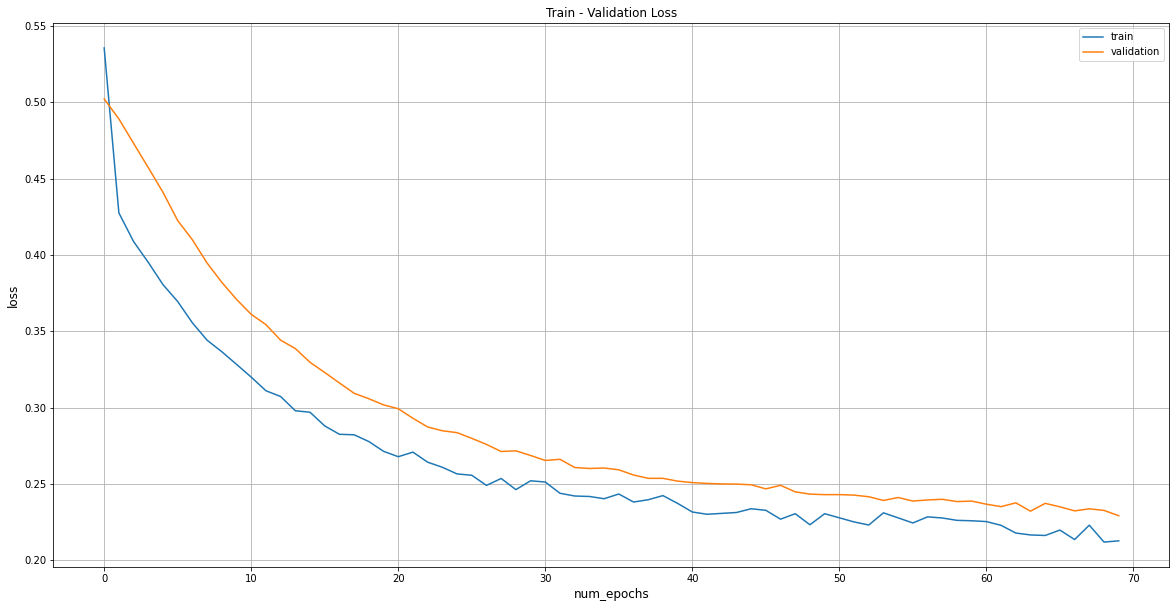

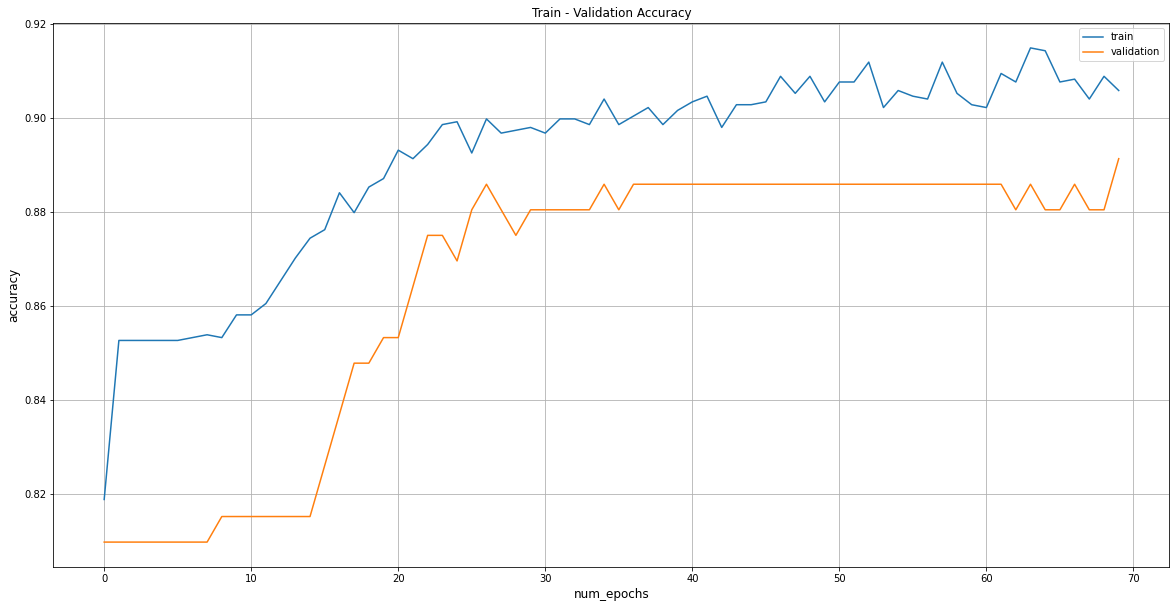

7/7 [==============================] - 5s 673ms/step - loss: 0.1838 - accuracy: 0.9314
Accuracy: 0.9313725233078003


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 7...
Epoch 1/70
52/52 [==============================] - 64s 1s/step - loss: 0.5054 - accuracy: 0.8394 - val_loss: 0.5192 - val_accuracy: 0.7935
Epoch 2/70
52/52 [==============================] - 48s 929ms/step - loss: 0.4249 - accuracy: 0.8502 - val_loss: 0.5042 - val_accuracy: 0.7935
Epoch 3/70
52/52 [==============================] - 48s 927ms/step - loss: 0.4097 - accuracy: 0.8502 - val_loss: 0.4811 - val_accuracy: 0.7935
Epoch 4/70
52/52 [==============================] - 48s 928ms/step - loss: 0.3902 - accuracy: 0.8502 - val_loss: 0.4574 - val_accuracy: 0.7935
Epoch 5/70
52/52 [==============================] - 48s 927ms/step - loss: 0.3787 - accuracy: 0.8502 - val_loss: 0.4359 - val_accuracy: 0.7935
Epoch 6/70
52/52 [==============================] - 48s 928ms/step - loss: 0.3661 - accuracy: 0.8502 - val_loss: 0.4143 - val_accuracy: 0.7935
Epoch 7/70
52/52 [==============================] - 51s 979ms/step - loss: 0.3533 - accuracy: 0.8502 - val_loss: 0.3993 -

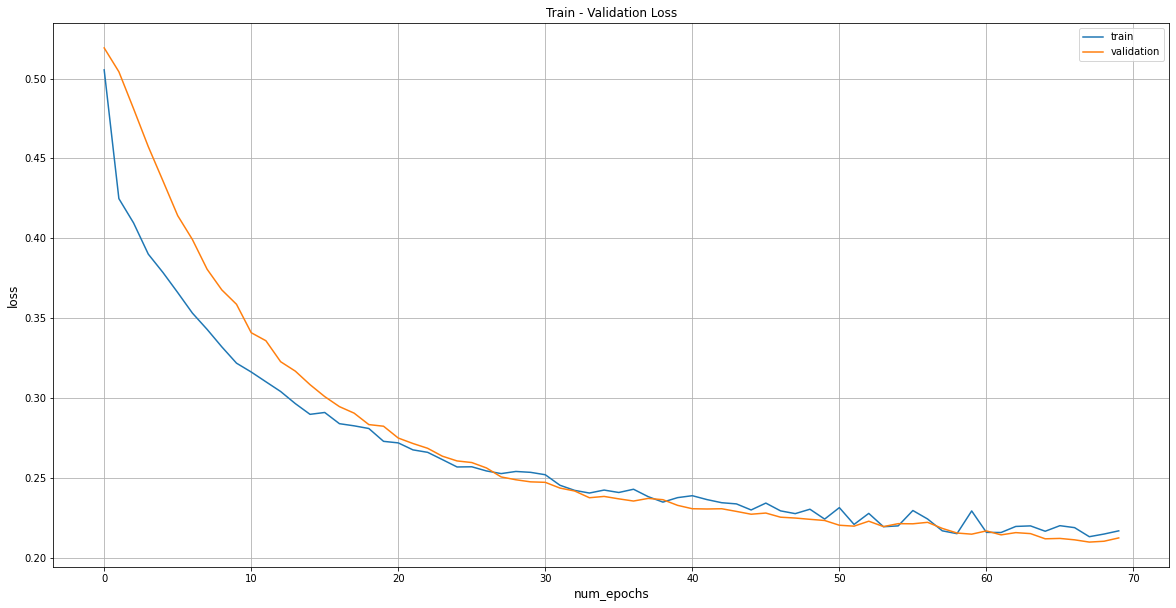

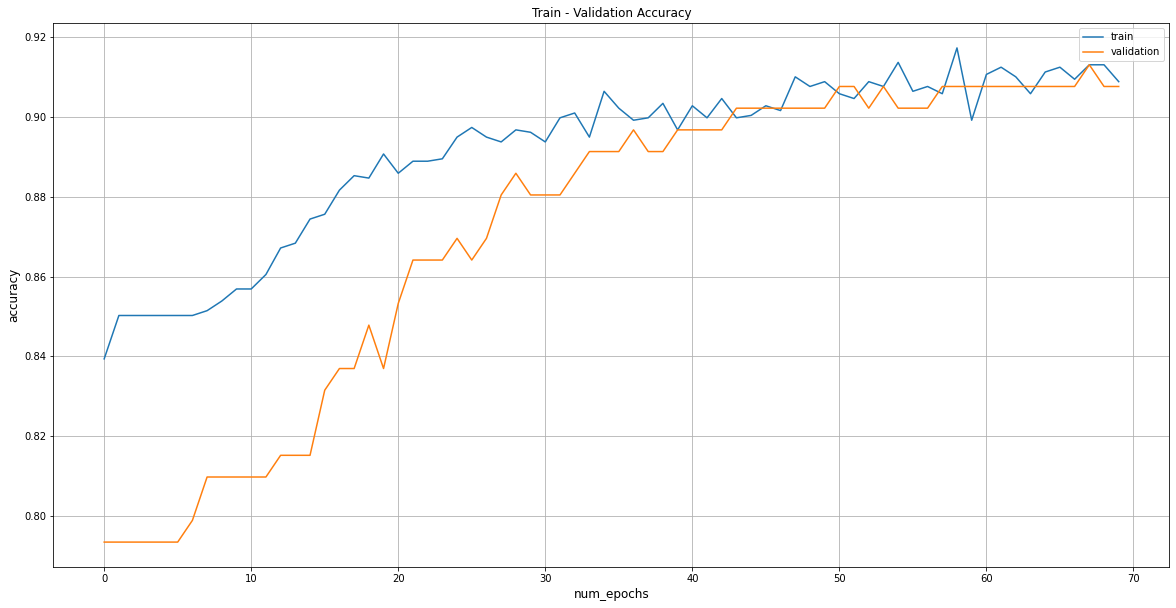

7/7 [==============================] - 5s 672ms/step - loss: 0.2184 - accuracy: 0.9020
Accuracy: 0.9019607901573181


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 8...
Epoch 1/70
52/52 [==============================] - 64s 1s/step - loss: 0.5410 - accuracy: 0.8140 - val_loss: 0.4986 - val_accuracy: 0.8152
Epoch 2/70
52/52 [==============================] - 48s 928ms/step - loss: 0.4263 - accuracy: 0.8563 - val_loss: 0.4781 - val_accuracy: 0.8152
Epoch 3/70
52/52 [==============================] - 48s 928ms/step - loss: 0.4028 - accuracy: 0.8563 - val_loss: 0.4616 - val_accuracy: 0.8152
Epoch 4/70
52/52 [==============================] - 48s 928ms/step - loss: 0.3873 - accuracy: 0.8563 - val_loss: 0.4435 - val_accuracy: 0.8152
Epoch 5/70
52/52 [==============================] - 48s 928ms/step - loss: 0.3756 - accuracy: 0.8563 - val_loss: 0.4255 - val_accuracy: 0.8152
Epoch 6/70
52/52 [==============================] - 48s 929ms/step - loss: 0.3614 - accuracy: 0.8563 - val_loss: 0.4079 - val_accuracy: 0.8152
Epoch 7/70
52/52 [==============================] - 48s 928ms/step - loss: 0.3546 - accuracy: 0.8563 - val_loss: 0.3941 -

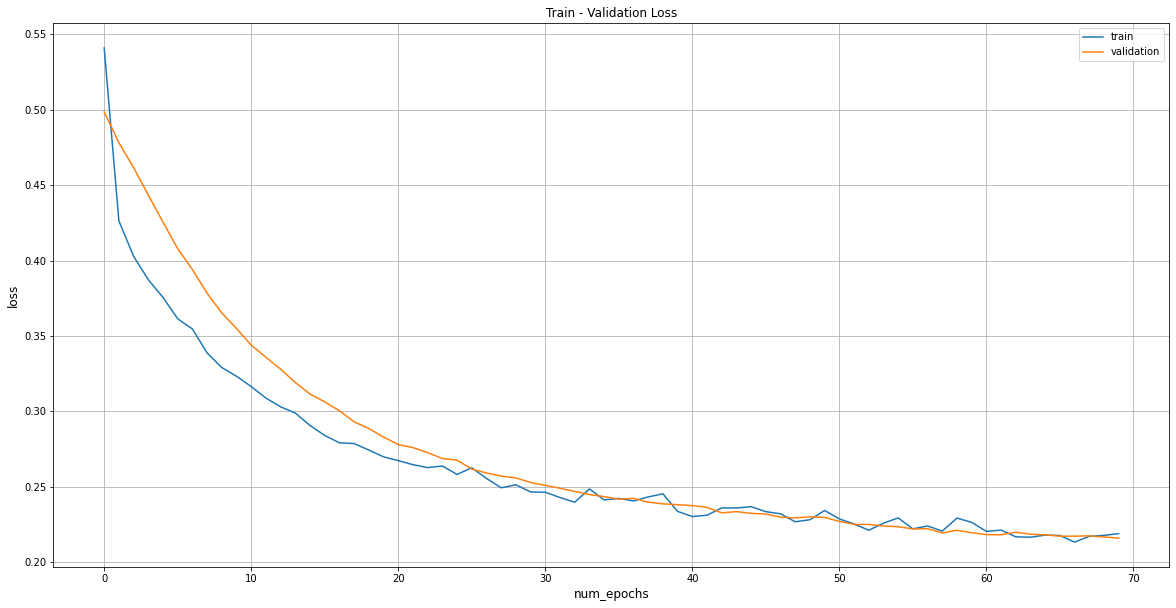

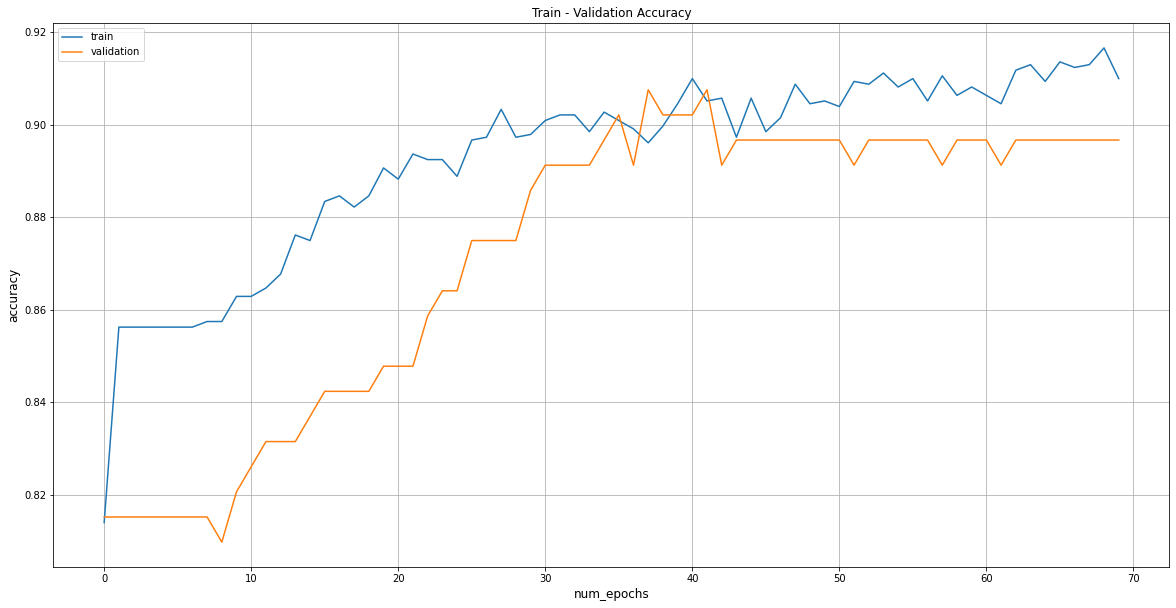

7/7 [==============================] - 5s 673ms/step - loss: 0.2431 - accuracy: 0.8873
Accuracy: 0.8872548937797546


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 9...
Epoch 1/70
52/52 [==============================] - 65s 1s/step - loss: 0.4943 - accuracy: 0.8460 - val_loss: 0.4778 - val_accuracy: 0.8098
Epoch 2/70
52/52 [==============================] - 48s 929ms/step - loss: 0.4103 - accuracy: 0.8527 - val_loss: 0.4650 - val_accuracy: 0.8098
Epoch 3/70
52/52 [==============================] - 48s 927ms/step - loss: 0.3919 - accuracy: 0.8527 - val_loss: 0.4467 - val_accuracy: 0.8098
Epoch 4/70
52/52 [==============================] - 48s 929ms/step - loss: 0.3786 - accuracy: 0.8527 - val_loss: 0.4258 - val_accuracy: 0.8098
Epoch 5/70
52/52 [==============================] - 48s 931ms/step - loss: 0.3637 - accuracy: 0.8527 - val_loss: 0.4115 - val_accuracy: 0.8098
Epoch 6/70
52/52 [==============================] - 48s 930ms/step - loss: 0.3521 - accuracy: 0.8533 - val_loss: 0.3946 - val_accuracy: 0.8098
Epoch 7/70
52/52 [==============================] - 48s 929ms/step - loss: 0.3405 - accuracy: 0.8539 - val_loss: 0.3796 -

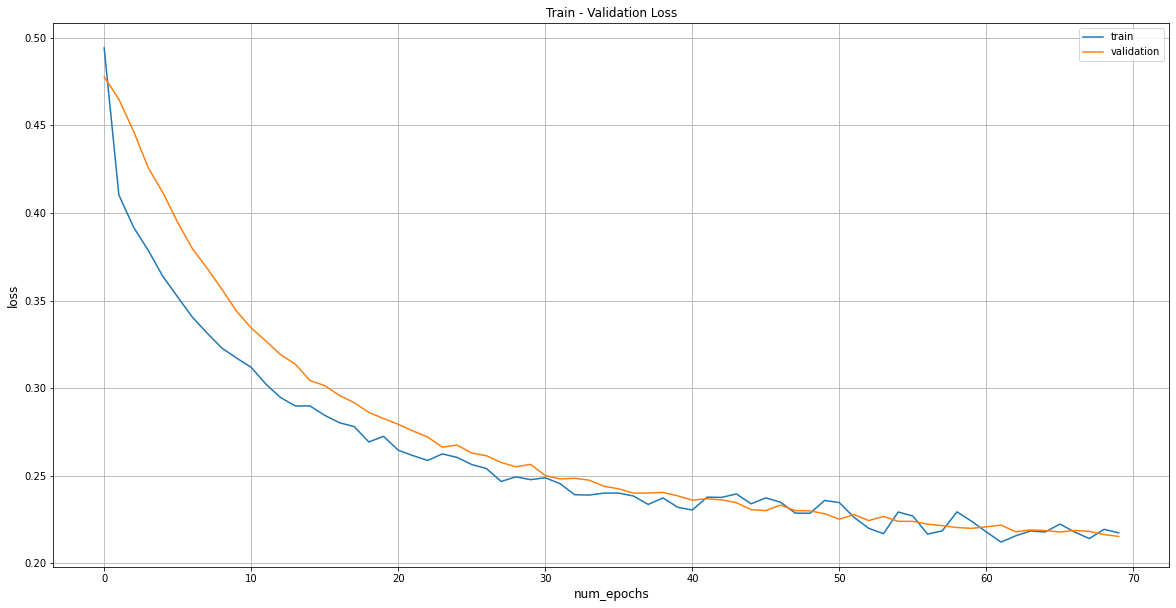

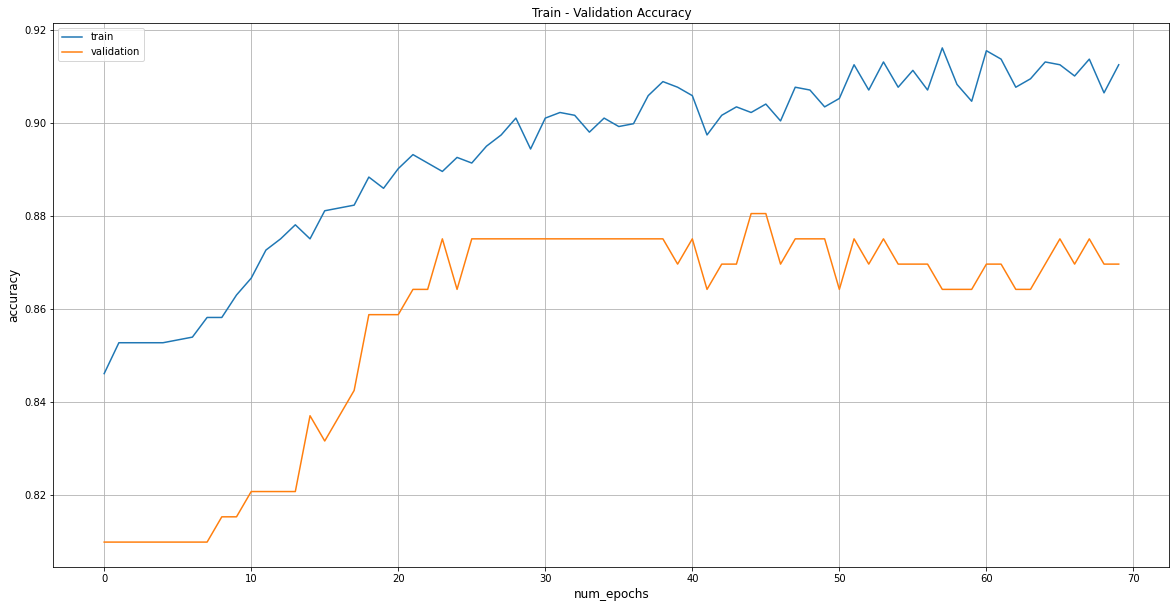

7/7 [==============================] - 5s 675ms/step - loss: 0.2476 - accuracy: 0.8922
Accuracy: 0.8921568393707275


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 10...
Epoch 1/70
52/52 [==============================] - 65s 1s/step - loss: 0.5860 - accuracy: 0.7289 - val_loss: 0.5310 - val_accuracy: 0.7772
Epoch 2/70
52/52 [==============================] - 48s 931ms/step - loss: 0.4331 - accuracy: 0.8539 - val_loss: 0.5202 - val_accuracy: 0.7772
Epoch 3/70
52/52 [==============================] - 48s 929ms/step - loss: 0.4084 - accuracy: 0.8539 - val_loss: 0.5094 - val_accuracy: 0.7772
Epoch 4/70
52/52 [==============================] - 48s 930ms/step - loss: 0.3934 - accuracy: 0.8539 - val_loss: 0.4945 - val_accuracy: 0.7772
Epoch 5/70
52/52 [==============================] - 48s 930ms/step - loss: 0.3791 - accuracy: 0.8539 - val_loss: 0.4735 - val_accuracy: 0.7772
Epoch 6/70
52/52 [==============================] - 48s 930ms/step - loss: 0.3673 - accuracy: 0.8539 - val_loss: 0.4513 - val_accuracy: 0.7772
Epoch 7/70
52/52 [==============================] - 48s 931ms/step - loss: 0.3550 - accuracy: 0.8539 - val_loss: 0.4365 

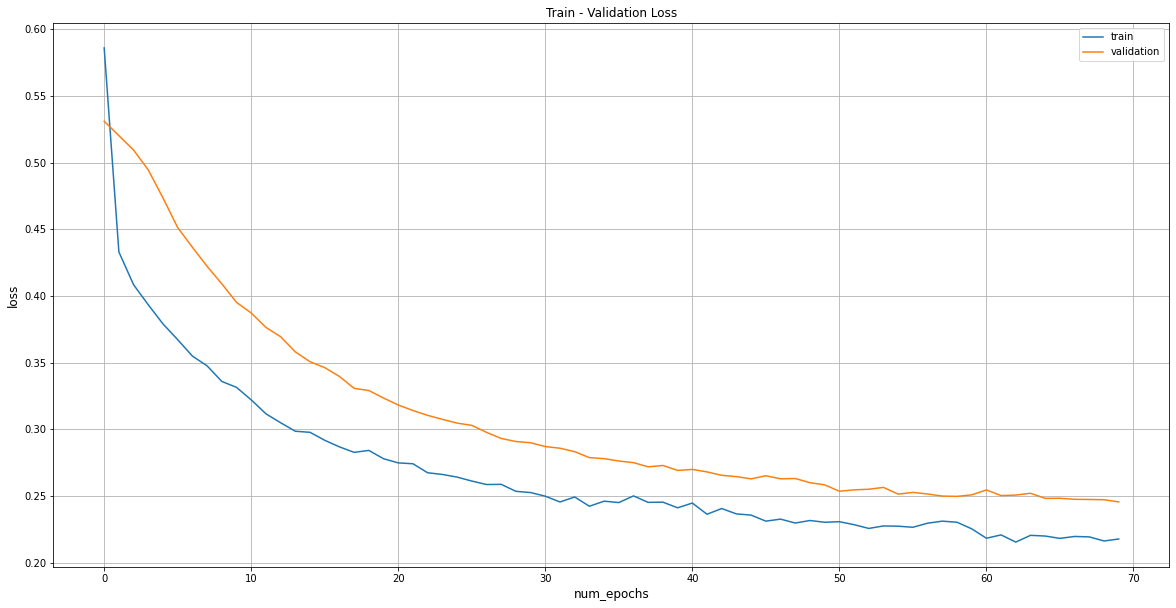

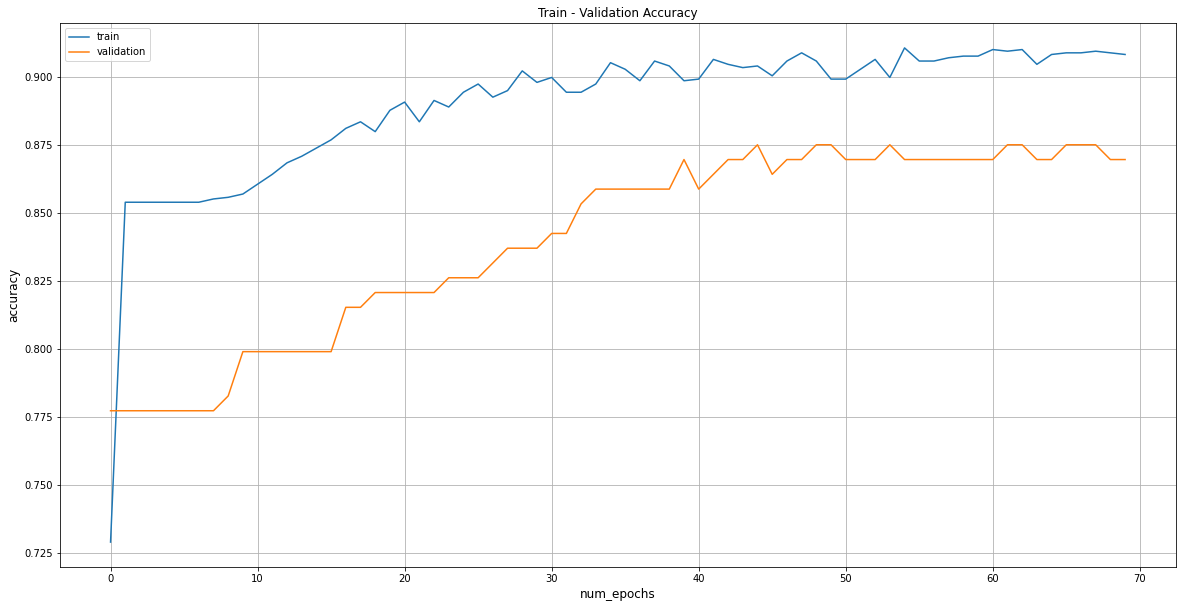

7/7 [==============================] - 5s 674ms/step - loss: 0.2208 - accuracy: 0.9069
Accuracy: 0.906862735748291


accuracy    0.899213
dtype: float64

In [ ]:
N_EPOCAS = 70
kfold = KFold(n_splits=10, shuffle=True)
acc = []
fold = 1
directory_checkpoint = "tfm/checkpoints/finanzas_tag_s_n/"
for train, test in kfold.split(dataset_labels.body_no_entities):
    
    fold_train_x = dataset_labels.body_no_entities.values[train]
    textos_train = tokenizer(fold_train_x.tolist(), padding="max_length", truncation=True, return_tensors="tf")
     
    fold_train_y = dataset_labels.finanzas_tag_s_n.values[train]
            
    model_checkpoint_callback = ModelCheckpoint(
        filepath=f'{directory_checkpoint}/fold_{fold}',
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=15, mode='min')
    
    # Para cada Fold se entrena de nuevo
    model = TFBertForSequenceClassification.from_pretrained(checkpoint, num_labels=N_LABELS)
    model.layers[0].trainable=False
    model.layers[-1].activation=tf.keras.activations.softmax
    
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(learning_rate=0.0001),
        metrics=['accuracy']
    )

    print(f"Starting with Fold {fold}...")

    hist = model.fit(
        textos_train.data,
        fold_train_y,
        validation_split=0.1,
        epochs=N_EPOCAS,
        callbacks=[model_checkpoint_callback, early_stopping]
        )
    
    fold_test_x = dataset_labels.body_no_entities.values[test]
    textos_test = tokenizer(fold_test_x.tolist(), padding="max_length", truncation=True, return_tensors="tf")
    
    fold_test_y = dataset_labels.finanzas_tag_s_n.values[test]

    fig = plt.figure(figsize=(20,10))
    plt.title("Train - Validation Loss")
    plt.plot(hist.history['loss'], label='train')
    plt.plot(hist.history['val_loss'], label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')
    plt.grid()
    plt.show()

    fig = plt.figure(figsize=(20,10))
    plt.title("Train - Validation Accuracy")
    plt.plot(hist.history['accuracy'], label='train')
    plt.plot(hist.history['val_accuracy'], label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('accuracy', fontsize=12)
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
    model.load_weights(f'{directory_checkpoint}/fold_{fold}')
    i_acc  = model.evaluate(textos_test.data, fold_test_y)
    print("Accuracy:", i_acc[1])
    acc.append(i_acc[1])
    
    fold += 1
result = pd.DataFrame({'accuracy':acc})
result.mean()

In [ ]:
result

,accuracy
0,0.887805
1,0.887805
2,0.902439
3,0.926829
4,0.867647
5,0.931373
6,0.901961
7,0.887255
8,0.892157
9,0.906863


In [ ]:
result.mean()

accuracy    0.899213
dtype: float64

In [ ]:
result

,accuracy
0,0.902778
1,0.921296
2,0.875000
3,0.875000
4,0.884259
5,0.912037
6,0.902326
7,0.911628
8,0.925581
9,0.939535


In [ ]:
result.mean()

accuracy    0.904944
dtype: float64